Recording 600 ADC samples to adc_data_1.csv...
Sample 1: A0 = 1577, A3 = 2766
Sample 2: A0 = 1658, A3 = 2894
Sample 3: A0 = 1593, A3 = 2785
Sample 4: A0 = 1612, A3 = 2770
Sample 5: A0 = 1691, A3 = 2902
Sample 6: A0 = 1620, A3 = 2782
Sample 7: A0 = 1651, A3 = 2795
Sample 8: A0 = 1725, A3 = 2912
Sample 9: A0 = 1649, A3 = 2783
Sample 10: A0 = 1691, A3 = 2807
Sample 11: A0 = 1751, A3 = 2920
Sample 12: A0 = 1674, A3 = 2769
Sample 13: A0 = 1727, A3 = 2816
Sample 14: A0 = 1768, A3 = 2886
Sample 15: A0 = 1698, A3 = 2760
Sample 16: A0 = 1762, A3 = 2832
Sample 17: A0 = 1778, A3 = 2864
Sample 18: A0 = 1724, A3 = 2760
Sample 19: A0 = 1791, A3 = 2854
Sample 20: A0 = 1774, A3 = 2836
Sample 21: A0 = 1731, A3 = 2762
Sample 22: A0 = 1793, A3 = 2863
Sample 23: A0 = 1733, A3 = 2797
Sample 24: A0 = 1701, A3 = 2751
Sample 25: A0 = 1746, A3 = 2862
Sample 26: A0 = 1659, A3 = 2754
Sample 27: A0 = 1636, A3 = 2730
Sample 28: A0 = 1682, A3 = 2850
Sample 29: A0 = 1583, A3 = 2731
Sample 30: A0 = 1578, A3 = 2715
Sa

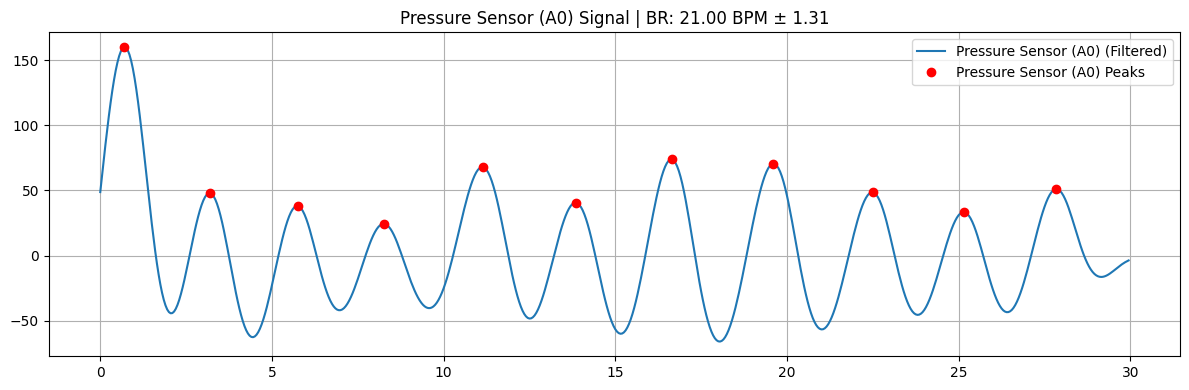

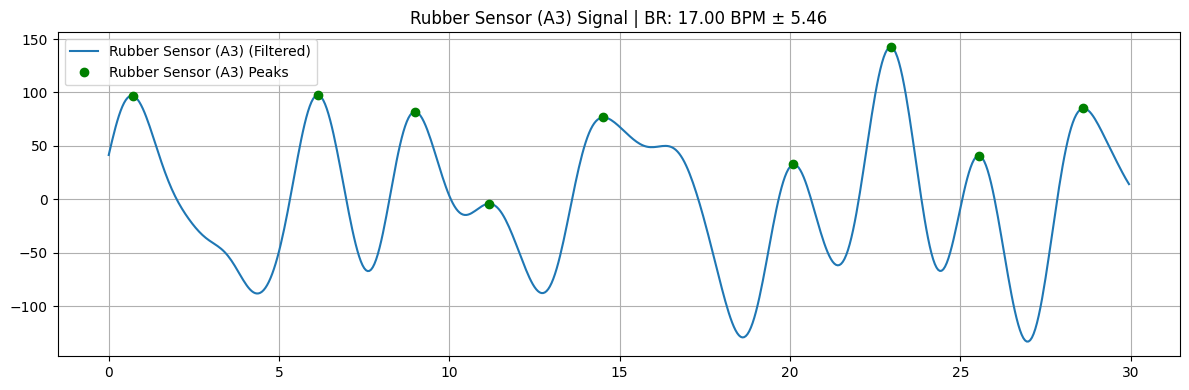

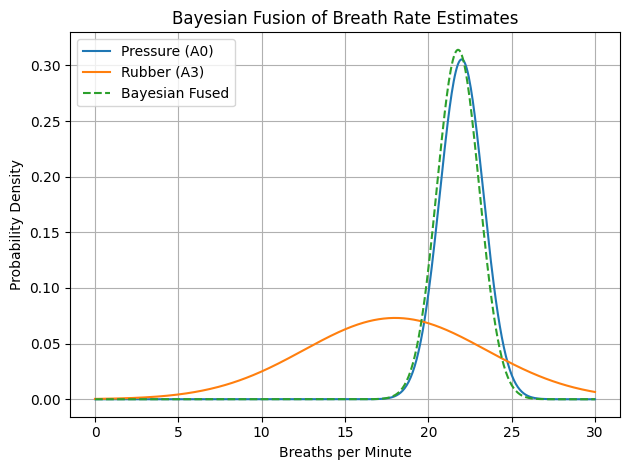


--- BREATH RATE ESTIMATION ---
Pressure Sensor (A0): 21.00 ± 1.31 BPM
Rubber Sensor (A3):  17.00 ± 5.46 BPM
Bayesian Fused:      20.78 ± 1.27 BPM


In [ ]:
import serial
import time
import os
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, butter, filtfilt
from scipy.stats import norm

# --------------------
# CONFIG
# --------------------
PORT = 'COM7'
BAUD_RATE = 115200
TIMEOUT = 1
N_SAMPLES = 600
DELAY_BETWEEN_SAMPLES = 0.05  # seconds
SUBFOLDER = 'breath_data'
TRACKER_FILE = os.path.join(SUBFOLDER, 'current_index.txt')
MAX_FILES = 5
fs = int(1 / DELAY_BETWEEN_SAMPLES)
min_breath_interval = 2  # seconds

# --------------------
# File Management
# --------------------
def get_next_file_index():
    if not os.path.exists(SUBFOLDER):
        os.makedirs(SUBFOLDER)
    if not os.path.exists(TRACKER_FILE):
        with open(TRACKER_FILE, 'w') as f:
            f.write('1')
        return 1
    with open(TRACKER_FILE, 'r') as f:
        index = int(f.read().strip())
    next_index = 1 if index >= MAX_FILES else index + 1
    with open(TRACKER_FILE, 'w') as f:
        f.write(str(next_index))
    return next_index

# --------------------
# Signal Processing
# --------------------
def bandpass_filter(signal, fs, lowcut=0.1, highcut=0.5, order=2):
    nyq = 0.5 * fs
    b, a = butter(order, [lowcut / nyq, highcut / nyq], btype='band')
    return filtfilt(b, a, signal)

def detect_peaks(signal, fs):
    min_dist = int(min_breath_interval * fs)
    peaks, _ = find_peaks(signal, distance=min_dist)
    return peaks

def compute_breath_rate(peaks, duration_sec):
    return (len(peaks) / duration_sec) * 60

def estimate_uncertainty(peaks, fs):
    if len(peaks) < 2:
        return 2.0
    intervals = np.diff(peaks) / fs
    br_estimates = 60.0 / intervals
    return np.std(br_estimates)

def bayesian_fusion(mu1, sigma1, mu2, sigma2):
    fused_mu = (mu1 / sigma1**2 + mu2 / sigma2**2) / (1 / sigma1**2 + 1 / sigma2**2)
    fused_sigma2 = 1 / (1 / sigma1**2 + 1 / sigma2**2)
    return fused_mu, np.sqrt(fused_sigma2)

# --------------------
# Plotting
# --------------------
def plot_signals(time, signal1, peaks1, label1, br1, sigma1, signal2, peaks2, label2, br2, sigma2):
    plt.figure(figsize=(12, 4))
    plt.plot(time, signal1, label=f'{label1} (Filtered)')
    plt.plot(time[peaks1], signal1[peaks1], 'ro', label=f'{label1} Peaks')
    plt.title(f'{label1} Signal | BR: {br1:.2f} BPM ± {sigma1:.2f}')
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 4))
    plt.plot(time, signal2, label=f'{label2} (Filtered)')
    plt.plot(time[peaks2], signal2[peaks2], 'go', label=f'{label2} Peaks')
    plt.title(f'{label2} Signal | BR: {br2:.2f} BPM ± {sigma2:.2f}')
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

def plot_bayesian_posterior(br1, sigma1, br2, sigma2, br_fused, sigma_fused):
    x = np.linspace(0, 30, 500)
    plt.plot(x, norm.pdf(x, br1, sigma1), label='Pressure (A0)')
    plt.plot(x, norm.pdf(x, br2, sigma2), label='Rubber (A3)')
    plt.plot(x, norm.pdf(x, br_fused, sigma_fused), label='Bayesian Fused', linestyle='--')
    plt.title('Bayesian Fusion of Breath Rate Estimates')
    plt.xlabel('Breaths per Minute')
    plt.ylabel('Probability Density')
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

# --------------------
# Main
# --------------------
def main():
    try:
        index = get_next_file_index()
        filename = f'adc_data_{index}.csv'
        filepath = os.path.join(SUBFOLDER, filename)

        values = []

        with serial.Serial(PORT, BAUD_RATE, timeout=TIMEOUT) as ser:
            time.sleep(2)
            ser.reset_input_buffer()
            print(f"Recording {N_SAMPLES} ADC samples to {filename}...")

            while len(values) < N_SAMPLES:
                line = ser.readline().decode().strip()
                if "A0" in line and "A3" in line:
                    try:
                        parts = line.replace("ADC", "").replace("=", "").replace(",", "").split()
                        val_a0 = int(parts[1])
                        val_a3 = int(parts[3])
                        values.append((val_a0, val_a3))
                        print(f"Sample {len(values)}: A0 = {val_a0}, A3 = {val_a3}")
                        time.sleep(DELAY_BETWEEN_SAMPLES)
                    except (ValueError, IndexError):
                        print("Malformed line:", line)

        # Save to CSV
        with open(filepath, 'w', newline='') as f:
            writer = csv.writer(f)
            writer.writerow(["Sample Number", "ADC A0", "ADC A3"])
            for i, (a0, a3) in enumerate(values, 1):
                writer.writerow([i, a0, a3])
        print(f"\nSaved data to {filepath}")

        # Convert to numpy arrays
        a0_vals = np.array([v[0] for v in values])
        a3_vals = np.array([v[1] for v in values])
        time_vector = np.arange(len(a0_vals)) / fs

        # Process signals
        a0_filtered = bandpass_filter(a0_vals, fs)
        a3_filtered = bandpass_filter(a3_vals, fs)
        duration_sec = len(a0_vals) / fs

        peaks_a0 = detect_peaks(a0_filtered, fs)
        peaks_a3 = detect_peaks(a3_filtered, fs)

        br_a0 = compute_breath_rate(peaks_a0, duration_sec)
        br_a3 = compute_breath_rate(peaks_a3, duration_sec)

        sigma_a0 = estimate_uncertainty(peaks_a0, fs)
        sigma_a3 = estimate_uncertainty(peaks_a3, fs)

        br_fused, sigma_fused = bayesian_fusion(br_a0, sigma_a0, br_a3, sigma_a3)

        # Plotting
        plot_signals(time_vector, a0_filtered, peaks_a0, "Pressure Sensor (A0)", br_a0, sigma_a0,
                     a3_filtered, peaks_a3, "Rubber Sensor (A3)", br_a3, sigma_a3)
        plot_bayesian_posterior(br_a0, sigma_a0, br_a3, sigma_a3, br_fused, sigma_fused)

        # Output Summary
        print(f"\n--- BREATH RATE ESTIMATION ---")
        print(f"Pressure Sensor (A0): {br_a0:.2f} ± {sigma_a0:.2f} BPM")
        print(f"Rubber Sensor (A3):  {br_a3:.2f} ± {sigma_a3:.2f} BPM")
        print(f"Bayesian Fused:      {br_fused:.2f} ± {sigma_fused:.2f} BPM")

    except serial.SerialException as e:
        print(f"Serial error: {e}")
    except KeyboardInterrupt:
        print("\nInterrupted by user.")

if __name__ == "__main__":
    main()
